<a href="https://colab.research.google.com/github/monanjo123/Fraud-Detection/blob/master/Fraud%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import os
import random
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import numpy as np
import scipy
import seaborn as sns
import copy
from pandas import concat, DataFrame
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
import zipfile

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


[[187865, 363], [4910, 1741]]


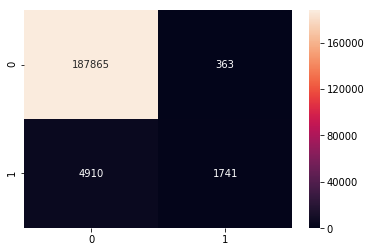

In [8]:
data = [[187865,363],[4910,1741]]

print(data)
sns.heatmap(data, annot=True, fmt='g')
plt.show()

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# unzip dataset zip file
local_zip = '/content/drive/My Drive/Machine Learning/datasets/ieee-fraud-detection.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/My Drive/Machine Learning/datasets/iiee-fraud-detection')
zip_ref.close()

# Explore Data

In [0]:
data_path ='/content/drive/My Drive/Machine Learning/datasets/iiee-fraud-detection'
train_transaction = pd.read_csv('{}/train_transaction.csv'.format(data_path), low_memory=False)

In [0]:
def reduce_mem_usage(df):
    numv = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2 
    for col in df.columns:
        vt = df[col].dtypes
        if vt in numv:
            max_c = df[col].max()
            min_c = df[col].min()
            if str(vt)[:3] == 'int':
                if min_c > np.iinfo(np.int8).min and max_c < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif min_c > np.iinfo(np.int16).min and max_c < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif min_c > np.iinfo(np.int32).min and max_c < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif min_c > np.iinfo(np.int64).min and max_c < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if min_c > np.finfo(np.float16).min and max_c < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif min_c > np.finfo(np.float32).min and max_c < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif min_c > np.finfo(np.float64).min and max_c < np.finfo(np.float64).max:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
train_transaction = reduce_mem_usage(train_transaction)

Mem. usage decreased to 542.35 Mb (69.4% reduction)


In [0]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# Delete Useless Columns
miss_data = pd.isnull(train_transaction).sum().sort_values(ascending=False)
miss_per = (miss_data/len(train_transaction))*100
missing_data = pd.concat(objs = [miss_data, miss_per], keys = ['Columns','Missing values percentage'], axis = 1)

In [0]:
def delnullcol(dt):
    nullcol = [col for col in dt.columns if dt[col].isnull().sum()/dt.shape[0] >= 0.9]
    return nullcol

In [0]:
rep_vals = [col for col in train_transaction.columns if train_transaction[col].value_counts(dropna = False, normalize = True).values[0] >= 0.9]
cols=[]
for col in rep_vals:
    cols.append(train_transaction[col].value_counts(dropna = False).values[0])

In [0]:
def repcols(dt):
    rep_vals = [col for col in dt.columns if dt[col].value_counts(dropna = False, normalize = True).values[0] >= 0.9]
    return rep_vals

In [0]:
def useless_cols(dt, exep):
    null_cols = delnullcol(dt)
    print("More than 90% null: " + str(len(null_cols)))
    too_many_repeated = repcols(dt)
    print("More than 90% repeated value: " + str(len(too_many_repeated)))
    cols_to_drop = list(set(null_cols + too_many_repeated))
    cols_to_drop.remove(exep)
    return cols_to_drop

In [0]:
cols_to_drop = useless_cols(train_transaction, 'isFraud')
train_transaction = train_transaction.drop(cols_to_drop, axis=1)

More than 90% null: 2
More than 90% repeated value: 57


In [0]:
X_cols = train_transaction.columns[4:]
y_cols = 'isFraud'
X = train_transaction[X_cols]
y = train_transaction[y_cols]
# print(X.dtypes)
# Categorical boolean mask
categorical_features = X.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical = X.columns[categorical_features].tolist()
print(categorical)
numerical_features = ~categorical_features
numerical = X.columns[numerical_features].tolist()
print(numerical)
X[categorical] = X[categorical].fillna('NA')
X[numerical] = X[numerical].fillna(-1)


['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', '

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [0]:
# save dataset
joblib.dump(X, '{}/datasetX.joblib'.format(data_path))
joblib.dump(y, '{}/datasetY.joblib'.format(data_path))

['/content/drive/My Drive/Machine Learning/datasets/iiee-fraud-detection/datasetY.joblib']

In [0]:
preprocess = make_column_transformer(
    (numerical, StandardScaler()),
    (categorical, OneHotEncoder())
)
new_X = preprocess.fit_transform(X)

/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:778: DeprecationWarning: `make_column_transformer` now expects (transformer, columns) as input tuples instead of (columns, transformer). This has been introduced in v0.20.1. `make_column_transformer` will stop accepting the deprecated (columns, transformer) order in v0.22.
  warnings.warn(message, DeprecationWarning)


In [0]:
print(y.values)
print(new_X.shape)
print(y.values.shape)
X_train, X_test, y_train, y_test = train_test_split(new_X, y.values, test_size=0.33)
del new_X, X, y
print(X_train, y_train)

[0 0 0 ... 0 0 0]
(590540, 484)
(590540,)
[[ 0.30345133  1.21616345 -0.20160017 ...  0.          1.
   0.        ]
 [-0.68733331 -0.92808513 -0.20160017 ...  0.          0.
   1.        ]
 [ 1.70760699  1.38819485 -0.20160017 ...  0.          0.
   1.        ]
 ...
 [-0.3221141   0.73078913 -0.20160017 ...  1.          0.
   0.        ]
 [-0.00871928  1.21616345 -0.20160017 ...  0.          0.
   1.        ]
 [-1.06030578 -1.51176311 -0.20160017 ...  0.          0.
   1.        ]] [0 0 0 ... 0 0 0]


# Logistic Regression

In [0]:
classifier_lr = LogisticRegression(random_state=0)
classifier_lr.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred = classifier_lr.predict(X_test)

In [0]:
model_performance('Logistic Regression', y_test, y_pred)

Model name: Logistic Regression
[[187865    363]
 [  4910   1741]]


In [0]:
from sklearn import metrics
def model_performance(model_name, y_test, Y_pred):
  print('Model name: {}'.format(model_name))
  cm = metrics.confusion_matrix(y_test, Y_pred)
  print(cm)
#   print('Test accuracy (Accuracy Score): {}').format(metrics.accuracy_)
#   score(y_test, Y_pred)
#   print ('Test accuracy (ROC AUC Score): {}').format(metrics.roc_auc_)
#   score(y_test, Y_pred)
#   print('Train accuracy: {}').format(clf.score(X_train, y_train))
#   fpr, tpr, thresholds = metrics.precision_recall_curve(y_test, Y_pred)
#   print('Area Under the Precision-Recall Curve: {}').format(metrics.auc(fpr, tpr))
#   false_positive_rate, true_positive_rate, thresholds = metrics.roc_
#   curve(y_test, Y_pred)
#   roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
#   plt.title('Receiver Operating Characteristic')
#   plt.plot(false_positive_rate, true_positive_rate, 'b',
#   label='AUC = %0.2f'% roc_auc)
#   plt.legend(loc='lower right')
#   plt.plot([0,1],[0,1],'r--')
#   plt.xlim([-0.1,1.2])
#   plt.ylim([-0.1,1.2])
#   plt.ylabel('True Positive Rate')
#   plt.xlabel('False Positive Rate')
#   plt.show()

# Support Vector Machine

In [0]:
from sklearn.svm import SVC

In [0]:
classifier_svm_rbf = SVC(kernel='rbf', random_state=0)
classifier_svm_rbf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [0]:
y_pred_rbf = classifier_svm_rbf.predict(X_test)
model_performance('SVM - RBF', y_test, y_pred_rbf)

In [0]:
classifier_svm_linear = SVC(kernel='linear', random_state=0)
classifier_svm_linear.fit(X_train, y_train)

In [0]:
y_pred_linear = classifier_svm_linear.predict(X_test)
model_performance('SVM - Linear', y_test, y_pred_linear)

# Decision Tree Classifier

In [0]:
from sklearn.tree import DecisionTreeClassifier

In [0]:
classifier_tree = DecisionTreeClassifier(criterion='entropy', random_state=0)
classifier_tree.fit(X_train, y_train)

In [0]:
y_pred_tree = classifier_svm_tree.predict(X_test)
model_performance('Decision Tree', y_test, y_pred_tree)